In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import sys
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from spec2D import Spec2D
from binnedFit_utilities import velocity_to_lambda

sys.path.append(dir_KLens)
from KLtool import plot_specs
from tfCube2 import TFCube

In [2]:
import astropy.units as u

# ========= generate example mock dataInfo ========= #

pars = {}
pars['g1'] = 0.05
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist

line_species='Halpha'

# ========= generate mocks ========= #

TF = TFCube(pars=pars, line_species=line_species)
dataInfo = TF.gen_mock_data(noise_mode=1)

# 0. create a Spec2D object

In [3]:
spec_array = dataInfo['spec'][0]
spec_var = dataInfo['spec_variance'][0]

print(f'original spec_array dim. = {spec_array.shape}')

spec2D = Spec2D(array=spec_array, array_var=spec_var, 
                spaceGrid=dataInfo['spaceGrid'], lambdaGrid=dataInfo['lambdaGrid'], 
                line_species=line_species, z=dataInfo['par_fid']['redshift'], auto_cut=True)

print(f'after auto_cut spec array dim. = {spec2D.array.shape}')

original spec_array dim. = (128, 122)
after auto_cut spec array dim. = (128, 122)


# 1. display

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/../../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff4b8dbec10>)

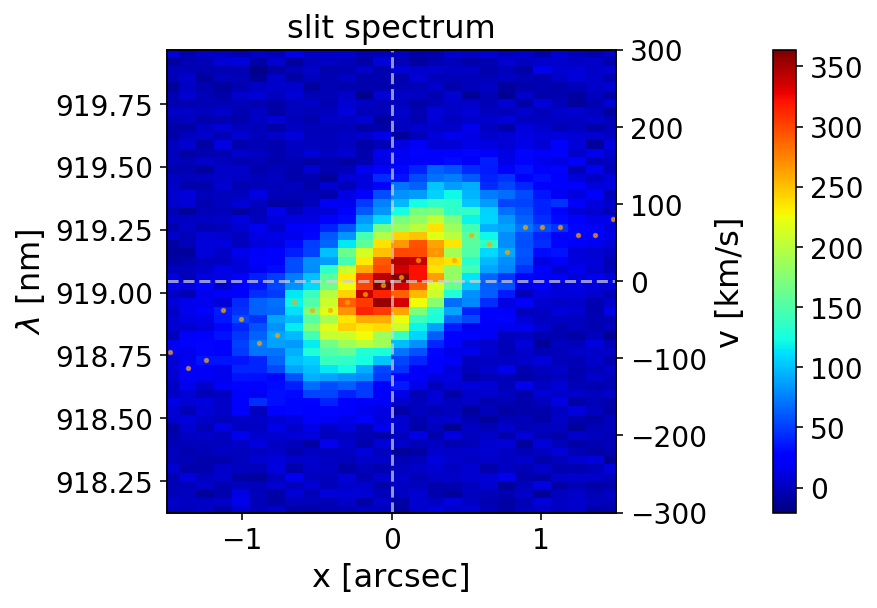

In [4]:
lambda0, z = dataInfo['par_fid']['lambda0'], dataInfo['par_fid']['redshift']
ylim = velocity_to_lambda(v=[-300.,300.], lambda0=lambda0, z=z)

spec2D.display(xlim=[-1.5,1.5], ylim=ylim, mark_cen=True, mark_peak=True)

### - mark_peak=True (display summary statistics)

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


RuntimeError for pos_id: 24. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 26. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 31. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 112. Set best-fit gaussian amp. = 0
time cost in gaussFit_spec2D: 0.3181290626525879 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff4a85383d0>)

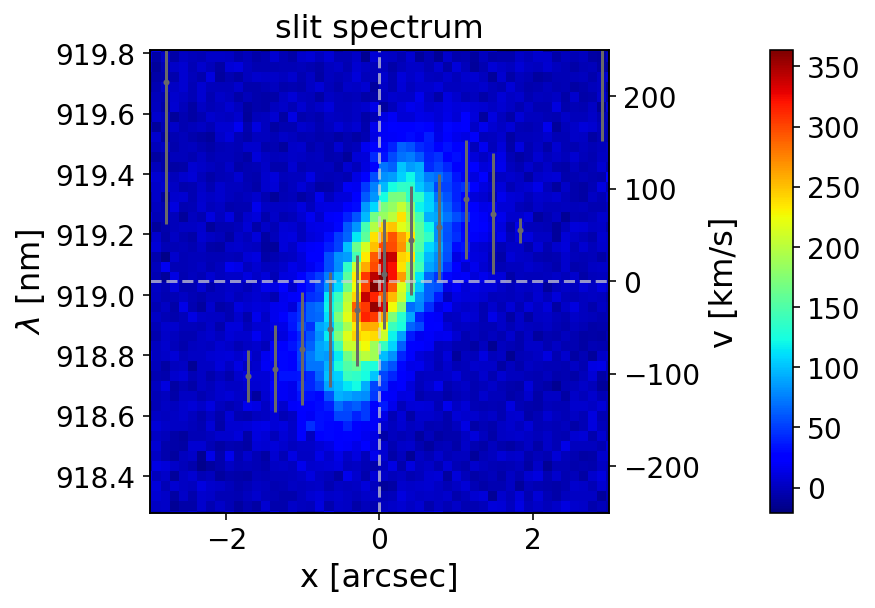

In [5]:
lambda0, z = dataInfo['par_fid']['lambda0'], dataInfo['par_fid']['redshift']

ylim = velocity_to_lambda(v=[-250.,250.], lambda0=lambda0, z=z)

spec2D.display(xlim=[-3.0,3.0], ylim=ylim, mark_cen=True, mark_fit=True)

### use keyward, model=model_arr to overplot model contours with data

In [6]:
from gaussFit import GaussFit
GF = GaussFit(spec2D=spec2D)
model = GF.model

RuntimeError for pos_id: 24. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 26. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 31. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 112. Set best-fit gaussian amp. = 0
time cost in gaussFit_spec2D: 0.287351131439209 (secs)


In [7]:
model.shape

(128, 122)

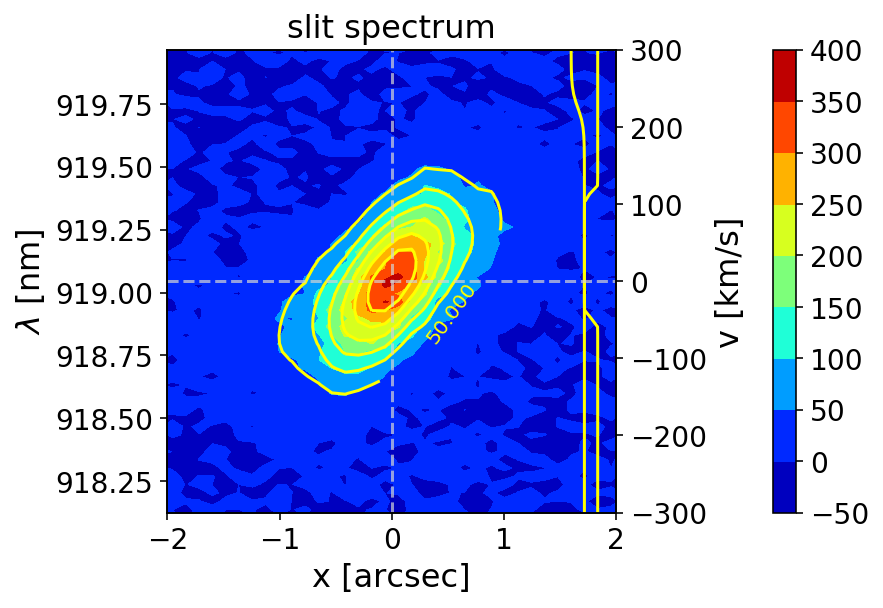

In [8]:
ylim = velocity_to_lambda(v=[-300.,300.], lambda0=lambda0, z=z)
fig, ax = spec2D.display(xlim=[-2.0,2.0], ylim=ylim, mark_cen=True, model=model)

### - overplot other things on top of ax

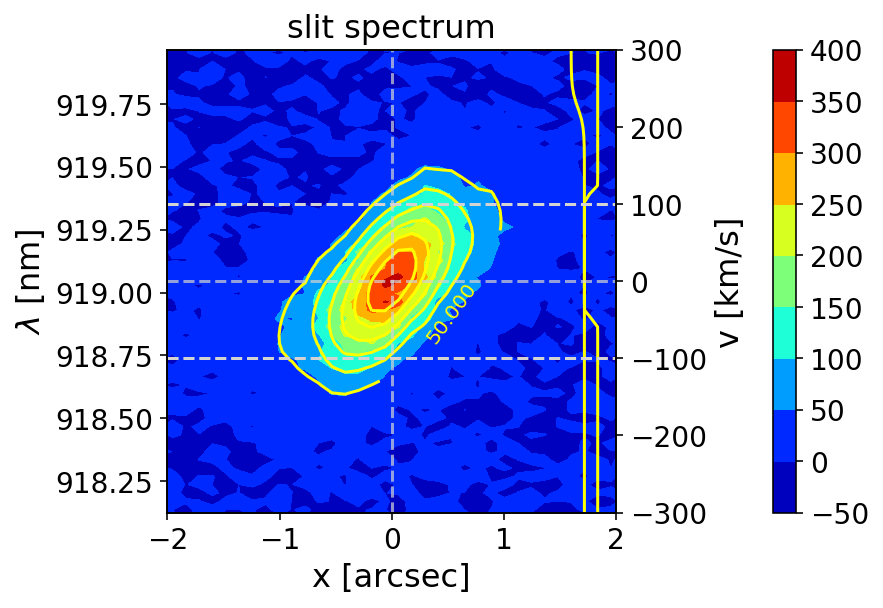

In [9]:
from IPython.display import display as ipython_display

lambda_mark = velocity_to_lambda(v=100., lambda0=lambda0, z=z)
ax.axhline(y=lambda_mark, color='lightgray', ls='--')

lambda_mark = velocity_to_lambda(v=-100., lambda0=lambda0, z=z)
ax.axhline(y=lambda_mark, color='lightgray', ls='--')

ipython_display(fig)

# 2. SNR for position bins

Text(0, 0.5, 'SNR')

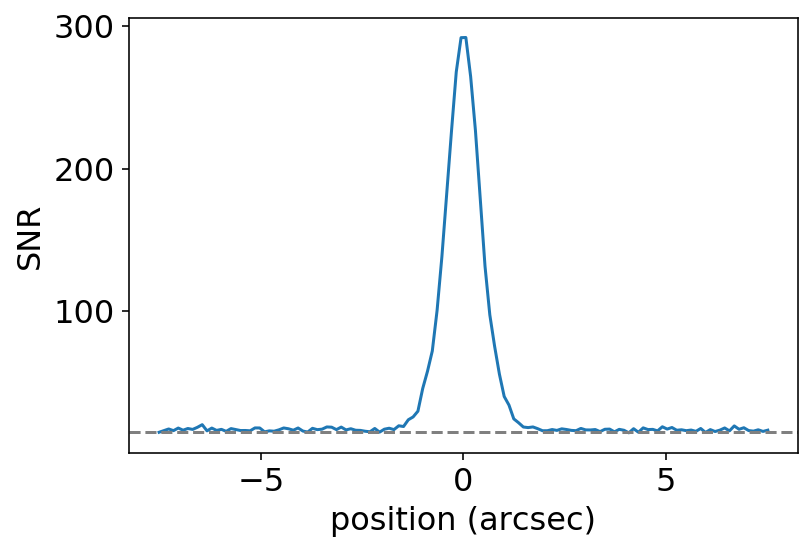

In [10]:
plt.plot(spec2D.spaceGrid, spec2D.SNR_pos)
plt.axhline(15, color='gray', ls='--')
plt.xlabel('position (arcsec)')
plt.ylabel('SNR')


# 3. cutout

### - cutout with thresholdSNR

before cutout : array.shape = (128, 122)
after cutout : array.shape = (99, 122)


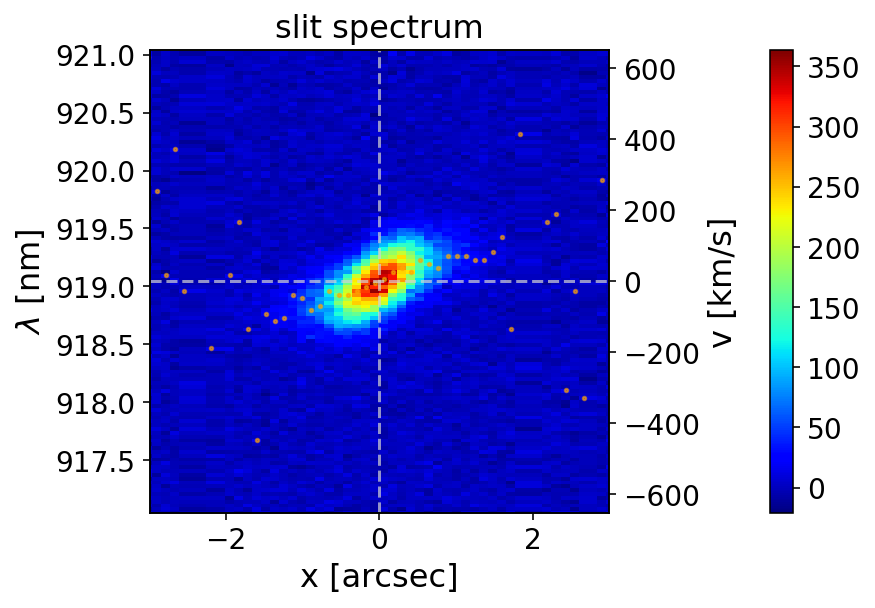

In [11]:
print(f'before cutout : array.shape = {spec2D.array.shape}')

spec2Dcut = spec2D.cutout(thresholdSNR=16)

print(f'after cutout : array.shape = {spec2Dcut.array.shape}')

fig, ax=spec2Dcut.display(mark_peak=True, xlim=[-3, 3], mark_cen=True)

### - cutout with xlim

before cutout : array.shape = (128, 122)
after cutout : array.shape = (34, 122)


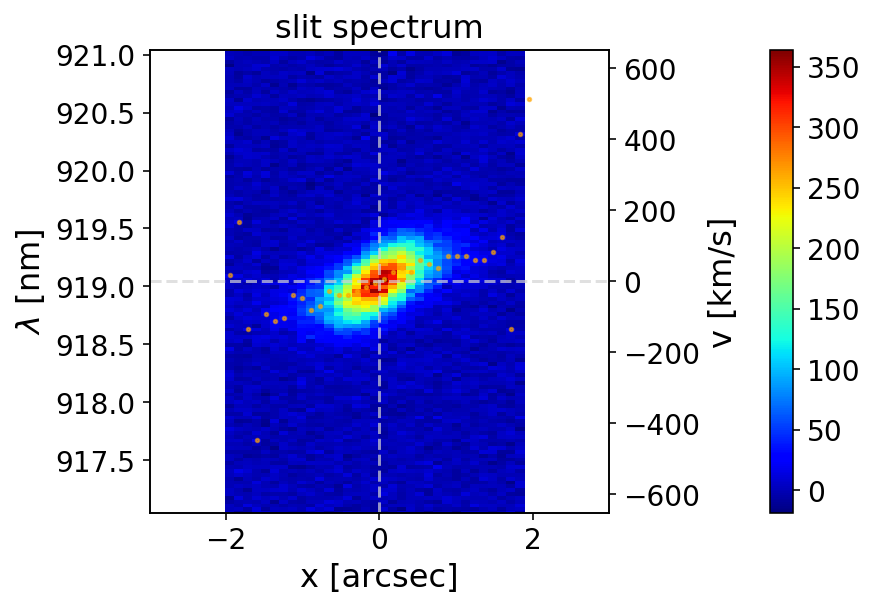

In [12]:
print(f'before cutout : array.shape = {spec2D.array.shape}')

spec2Dcut = spec2D.cutout(xlim=[-2,2])

print(f'after cutout : array.shape = {spec2Dcut.array.shape}')

fig, ax=spec2Dcut.display(mark_peak=True, xlim=[-3, 3], mark_cen=True)

# ------ END ------

In [13]:
spec2D.lambda0

656.461